In [1]:
# Install package to be able to save keras weights
pip install h5py

In [2]:
pip install nibabel

In [3]:
# Mount google drive
from google.colab import drive
import os
drive.mount('my_drive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at my_drive


In [10]:
from keras.callbacks import Callback

# What value maps to what class
mapping = {
    0: "Null class",
    1: "Necrotic and non-enhancing tumor core",
    2: "Edema",
    4: "GD-enhancing tumor"
}

# fixme: skulle gå att göra bättre igenom att skicka med en tex tuple med titlarna
# och returnera ett matplotlib-objekt istället för då hade man inte behövt ha olika
# funktioner för "plot_modalities" och "plt_OHE" och också kunna ha två stycken figurer med 
# 2*2 subplots i en cell.
def plot_modalities(x):
    # Make sure input data is of correct shape
    assert x.shape == (240, 240, 4), 'Shape of input data is incorrect'
    
    plt.subplot('221')
    plt.imshow(x[:,:,0])
    plt.axis('off')
    plt.title('T1')
    plt.colorbar()

    plt.subplot('222')
    plt.imshow(x[:,:,1])
    plt.axis('off')
    plt.title('T1ce')
    plt.colorbar()

    plt.subplot('223')
    plt.imshow(x[:,:,2])
    plt.axis('off')
    plt.title('T2')
    plt.colorbar()

    plt.subplot('224')
    plt.imshow(x[:,:,3])
    plt.axis('off')
    plt.title('FLAIR')
    plt.colorbar()

def plot_OHE(y):
    # Make sure input data is of correct shape
    assert y.shape == (240, 240, 4), 'Shape of input data is incorrect'
    
    plt.subplot('221')
    plt.imshow(y[:,:,0])
    plt.axis('off')
    plt.title('Null')
    plt.colorbar()

    plt.subplot('222')
    plt.imshow(y[:,:,1])
    plt.axis('off')
    plt.title('"Necrotic and non-enhancing tumor core"')
    plt.colorbar()

    plt.subplot('223')
    plt.imshow(y[:,:,2])
    plt.axis('off')
    plt.title('Edema')
    plt.colorbar()

    plt.subplot('224')
    plt.imshow(y[:,:,3])
    plt.axis('off')
    plt.title('GD-enhancing tumor')
    plt.colorbar()

def shift_and_scale(x):
    assert len(x.shape) == 2, 'The input must be 2 dimensional'
    result = x - np.mean(x)
    result /= np.std(x)
    return result

def OHE(Y, mapping):
    '''
    Takes in a picture as a matrix with labels and returns a one hot encoded tensor
    
    Parameters:
    Y is the picture
    Mapping is what value corresponds to what label
    
    Returns:
    A tensor with a channel for each label.
    '''
    shape = Y.shape
    labels = mapping.keys()
    one_hot_enc = np.zeros(list(shape) + [len(labels)])
    
    for i, label in enumerate(labels):
        temp = np.zeros(shape)
        ind = Y == label
        temp[ind] = 1
        one_hot_enc[:, :, i] = temp
    return one_hot_enc

#fixme: I don't know if providing this mapping is necessary
# probably could be provided inside function instead.
def OHE_uncoding(y, mapping):
    result = np.argmax(y, axis=2)
    labels = mapping.keys()
    temp = np.zeros(result.shape)
    for i, label in enumerate(labels):
        ind = result == i
        temp[ind] = label
    return temp

def intersection_over_union(y_true, y_pred):
    print(y_true.shape)
    print(y_pred.shape)
    
    values = np.array([0., 1.])
    unique_y_pred = np.unique(y_pred)
    unique_y_true = np.unique(y_true)
    assert np.array_equal(y_pred.shape, y_true.shape), 'Prediction and ground truth must have same shape'
    assert np.array_equal(values, unique_y_pred), 'yhat and y must be one hot encodings'
    assert np.array_equal(values, unique_y_true), 'yhat and y must be one hot encodings'
    
    # The slicing in the last index is because the null class bloats
    # the intersection over union because there are so many pixels which
    # have the value zero
    y_pred[:,:,0] = y_pred[:,:,0] == False
    y_true[:,:,0] = y_true[:,:,0] == False
    #intersection = (yhat[:,:,1:3] + y[:,:,1:3]) == 2
    #union = (yhat[:,:,1:3] + y[:,:,1:3]) > 0
    
    # Intersection is where there is 2 True values
    intersection = (y_pred + y_true) == 2
    # Union is where it is not zero
    union = (y_pred + y_true) > 0
    
    size_int = np.count_nonzero(intersection)
    size_uni = np.count_nonzero(union)
    
    return size_int/size_uni


# Load config file to session here
import json
config_path = "/content/my_drive/My Drive/EXJOBB/training_sessions/Session_0/config_0.json"
with open(config_path, 'r') as config_file:
    config = json.load(config_file)

class CallbackJSON(Callback):
    """ CallbackJSON descends from Callback
        and is used to write the number of training samples that the model has been trained on
        and the loss for a epoch
    """
    def __init__(self, config):
        """Save params in constructor
        config: Is a dictionary loaded from a JSON file which is used to keep track of training
        """
        self.config = config
        self.config_path = config['config_path']

    def on_epoch_end(self, epoch, logs):
        """
        Updates the history of the config dict and saves it to a file
        """
        # How many effective training samples have been used
        self.config['history']['training_samples_used'] += self.config['samples_used']
        
        # Logs the loss of the current epoch
        self.config['history']['loss'].append(logs['loss'])
        #fixme: add the same code but for "val_loss"
        # Save new config file
        with open(self.config_path, "w") as f:
            f.write(json.dumps(self.config))

print('Finished')

Finished


In [5]:
print(config)

{'weights_path': '/content/my_drive/My Drive/EXJOBB/training_sessions/Session_0/session_0_weights.h5', 'config_path': '/content/my_drive/My Drive/EXJOBB/training_sessions/Session_0/config_0.json', 'samples_used': 1, 'keep_training': False, 'history': {'training_samples_used': 0, 'loss': [], 'val_loss': []}}


In [6]:
import nibabel as nib
import matplotlib.pyplot as plt
import numpy as np
import glob
from os import listdir

path_t1 = "/content/my_drive/My Drive/EXJOBB/MICCAI_BraTS_2019_Data_Training (1)/HGG/BraTS19_2013_18_1/BraTS19_2013_18_1_t1.nii.gz"
path_t1ce = "/content/my_drive/My Drive/EXJOBB/MICCAI_BraTS_2019_Data_Training (1)/HGG/BraTS19_2013_18_1/BraTS19_2013_18_1_t1ce.nii.gz"
path_t2 = "/content/my_drive/My Drive/EXJOBB/MICCAI_BraTS_2019_Data_Training (1)/HGG/BraTS19_2013_18_1/BraTS19_2013_18_1_t2.nii.gz"
path_flair = "/content/my_drive/My Drive/EXJOBB/MICCAI_BraTS_2019_Data_Training (1)/HGG/BraTS19_2013_18_1/BraTS19_2013_18_1_flair.nii.gz"
path_gt = "/content/my_drive/My Drive/EXJOBB/MICCAI_BraTS_2019_Data_Training (1)/HGG/BraTS19_2013_18_1/BraTS19_2013_18_1_seg.nii.gz"
img = (path_t1)

img_t1 = nib.load(path_t1)
img_t1ce = nib.load(path_t1ce)
img_t2 = nib.load(path_t2)
img_flair = nib.load(path_flair)
img_gt = nib.load(path_gt)

img_t1 = img_t1.get_fdata()
img_t1ce = img_t1ce.get_fdata()
img_t2 = img_t2.get_fdata()
img_flair = img_flair.get_fdata()
img_gt = img_gt.get_fdata()

# I have here chosen to do shift and scale per image, which is not the only way to do it.
for i in range(img_t1.shape[2]):
    # shift and scale data
    img_t1[:, :, i] = shift_and_scale(img_t1[:, :, i])
    img_t1ce[:, :, i] = shift_and_scale(img_t1ce[:, :, i])
    img_t2[:, :, i] = shift_and_scale(img_t2[:, :, i])
    img_flair[:, :, i] = shift_and_scale(img_flair[:, :, i])
    
uncorrected_data = np.zeros((155, 240, 240, 4))

# The last axis will become the first axis
uncorrected_data[:, :, :, 0] = np.moveaxis(img_t1, -1, 0)
uncorrected_data[:, :, :, 1] = np.moveaxis(img_t1ce, -1, 0)
uncorrected_data[:, :, :, 2] = np.moveaxis(img_t2, -1, 0)
uncorrected_data[:, :, :, 3] = np.moveaxis(img_flair, -1, 0)

num_slices = 155
uncorrected_OHE_labels = np.zeros((num_slices, 240, 240, 4))

for j in range(num_slices):
    uncorrected_OHE_labels[j, :, :, :] = OHE(img_gt[:, :, j], mapping)
print('Finished')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:74: RuntimeWarning: invalid value encountered in true_divide


Finished


In [0]:
# Load numpy data and necessary packages
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

#path_data = "/content/my_drive/My Drive/Exjobb2/numpy_data.npy"
##path_labels = "/content/my_drive/My Drive/Exjobb2/numpy_labels.npy"
#data = np.load(path_data)
#OHE_labels = np.load(path_labels)

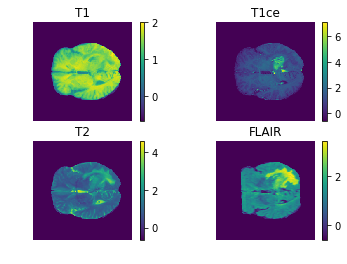

In [7]:
# This will show a slice of a patient
ind = 70

plot_modalities(uncorrected_data[ind, :, :, :])

In [0]:
import numpy as np
import os
import skimage.io as io
import skimage.transform as trans
import numpy as np
from keras.models import *
from keras.layers import *
from keras.activations import *
from keras.optimizers import *
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras import backend as keras

def unet(pretrained_weights = None, input_size = (256, 256, 1), num_classes=1):
  inputs = Input(input_size)
  conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
  conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
  pool1 = MaxPooling2D(pool_size = (2, 2))(conv1)
  
  conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
  conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
  pool2 = MaxPooling2D(pool_size = (2, 2))(conv2)
  
  conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
  conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
  pool3 = MaxPooling2D(pool_size = (2, 2))(conv3)
  
  conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
  conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
  drop4 = Dropout(0.5)(conv4)
  pool4 = MaxPooling2D(pool_size = (2, 2))(drop4)
  
  conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
  conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
  drop5 = Dropout(0.5)(conv5)
  
  up6 = Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2, 2))(drop5))
  merge6 = concatenate([drop4, up6], axis = 3)
  conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
  conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)
  
  up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2, 2))(conv6))
  merge7 = concatenate([conv3, up7], axis = 3)
  conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
  conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)
  
  up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2, 2))(conv7))
  merge8 = concatenate([conv2, up8], axis = 3)
  conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
  conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)
  
  up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2, 2))(conv8))
  merge9 = concatenate([conv1, up9], axis = 3)
  conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
  conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
  conv9 = Conv2D(num_classes, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
  
  reshape = Reshape((num_classes, input_size[0] * input_size[1]), input_shape = (num_classes, input_size[0], input_size[1]))(conv9)
  permute = Permute((2, 1))(reshape)
  activation = Softmax(axis=-1)(permute)
  
  model = Model(input = inputs, output = activation)
  model.compile(optimizer = Adam(lr=0.001), loss = 'categorical_crossentropy')
  if (pretrained_weights):
    model.load_weights(pretrained_weights)
  return model

In [0]:
# Initialise unet with untrained weights
my_unet = unet(input_size = (240, 240, 4), num_classes = 4)

# Train model
# n is how many samples to use at any time
n = 16
N = 16
epochs = 1
my_history = []
for e in range(epochs):
  print('\nEpoch: ' + str(e))
  for i in range(N//n):
#    if i % 5 == 0:
#        print('%', end='')
    # Pick n random slices
    #slices = np.random.randint(N, size=(n,))
    slices = 500
    train_data = data[1:slices, :, :, :]
    train_labels = OHE_labels[1:slices, :, :, :]

    # You have to reshape the output in this hacky way for keras to be able to use softmax in last layer
    train_labels = train_labels.reshape(slices, -1, 4)

    # Returns an object with accuracy and loss
    history = my_unet.fit(x=train_data, y=train_labels, batch_size=8, epochs=1, verbose=2, callbacks=None, validation_split=0.0, validation_data=None, shuffle=True, class_weight=None, sample_weight=None, initial_epoch=0, steps_per_epoch=None, validation_steps=None, validation_freq=1)
    my_history.append(history.history['loss'])
my_unet.save_weights("/content/my_drive/My Drive/Exjobb2/my_unet.h5")

In [0]:
# Initialise unet with untrained weights
my_unet = unet(input_size = (240, 240, 4), num_classes = 4)

print('data.shape: ' + str(data.shape))
print('OHE_labels.shape: ' + str(OHE_labels.shape))
labels = OHE_labels.reshape(775, -1, 4)
print('labels.shape: ' + str(labels.shape))

# If we want to save the model with val_loss in name
#filepath = 'weights.{epoch:02d}-{val_loss:.2f}.hdf5'

#path_to_weights_many_weights = "/content/my_drive/My Drive/Exjobb2/weights{epoch:08d}.h5"
path_to_weights = "/content/my_drive/My Drive/Exjobb2/unet_weights.h5"
mc = ModelCheckpoint(path_to_weights, save_weights_only=True, period=1)

# Returns an object with accuracy and loss
history = my_unet.fit(x=data, y=labels, batch_size=None, epochs=5, verbose=1, callbacks=[mc], validation_split=0.0, validation_data=None, shuffle=True, class_weight=None, sample_weight=None, initial_epoch=0, steps_per_epoch=None, validation_steps=None, validation_freq=1)

# Save weights of model
#my_unet.save_weights("/content/my_drive/My Drive/Exjobb2/my_unet.h5")
# convert the history.history dict to a pandas DataFrame:     
hist_df = pd.DataFrame(history.history) 
# or save to csv: 
hist_csv_file = '/content/my_drive/My Drive/Exjobb2/history.csv'
with open(hist_csv_file, mode='w') as f:
    hist_df.to_csv(f)

# New main training cell

In [0]:
# The path to where to save weights and initialize ModelCheckpoint
weights_path = config['weights_path']
from keras.callbacks import ModelCheckpoint
MyModelCheckPoint = ModelCheckpoint(weights_path, verbose=0, save_weights_only=True)

if config['keep_training'] == True:
    # Keep training on the old weights
    my_unet.load_weights(weights_path)
else:
    # Initialize network
    my_unet = unet(input_size = (240, 240, 4), num_classes = 4)
    config['keep_training'] = True
    
samples_used = 100
# i = 70 has all labels present in the image
n = uncorrected_data.shape[0]
i = np.random.randint(n, size=[samples_used,])
x = uncorrected_data[i, :, :, :]
y = uncorrected_OHE_labels[i, :, :, :]

x = x[0, :, :, :].reshape(1, 240, 240, 4)
# You have to reshape the output in this hacky way for keras to be able to use softmax in last layer
y = y[0, :, :, :].reshape(1, -1, 4)

# Returns an object with accuracy and loss
history = my_unet.fit(x=x, 
                      y=y, 
                      batch_size=None,
                      epochs=500, 
                      verbose=0, 
                      callbacks=[CallbackJSON(config=config), MyModelCheckPoint],
                      validation_split=0.0, 
                      validation_data=None, 
                      shuffle=True, 
                      class_weight=None, 
                      sample_weight=None, 
                      initial_epoch=0, 
                      steps_per_epoch=1, 
                      validation_steps=None, 
                      validation_freq=1)


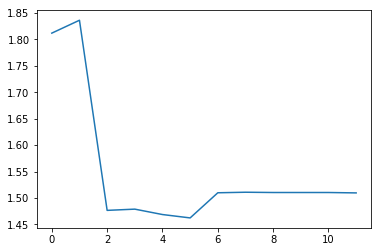

In [12]:
loss = config['history']['loss']

plt.plot(loss)